In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
data=pd.read_hdf('../data/Figure1.h5', key='data')

In [3]:
synthetic_viz = data['synthetic_viz']
synthetic_scores = {k: data['synthetic_scores'][k] for k in ['cebra','pivae', 'umap', 'tsne']}
viz = data['visualization']

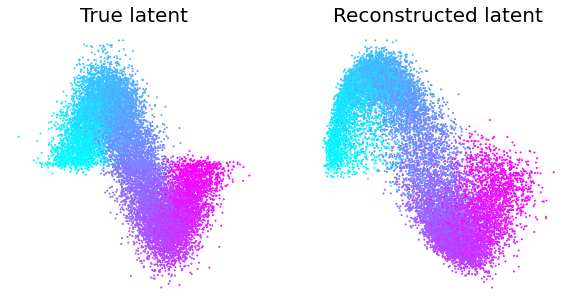

In [4]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax1.scatter(synthetic_viz['true'][:,0], synthetic_viz['true'][:,1], s=1,c = synthetic_viz['label'], cmap='cool')
ax1.axis('off')
ax1.set_title('True latent', fontsize=20)
ax2 = plt.subplot(122)
ax2.axis('off')
ax2.set_title('Reconstructed latent', fontsize=20)
ax2.scatter(synthetic_viz['cebra'][:,0], synthetic_viz['cebra'][:,1],s=1,c = synthetic_viz['label'], cmap='cool')

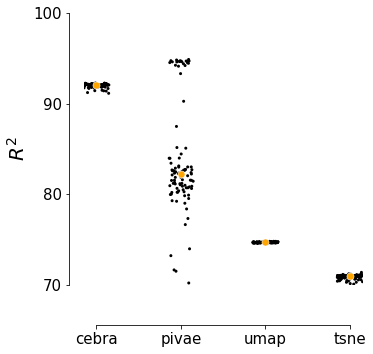

In [5]:
plt.figure(figsize=(5,5))
ax=plt.subplot(111)

df = pd.DataFrame(synthetic_scores)
sns.stripplot(data=df*100, color = 'black', s=3, zorder=1, jitter=0.15)
sns.scatterplot(data=df.median()*100, color = 'orange', s=50)
plt.xticks([0,1,2,3], list(synthetic_scores.keys()), fontsize = 20, rotation = 45)
plt.ylabel('$R^2$', fontsize=20)
plt.yticks(np.linspace(0,100,11, dtype = int), np.linspace(0,100,11, dtype=int), fontsize=20)
plt.ylim(70, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
sns.despine(left = False, right=True, bottom = False, top = True, trim = True, offset={'bottom':40, 'left':15})

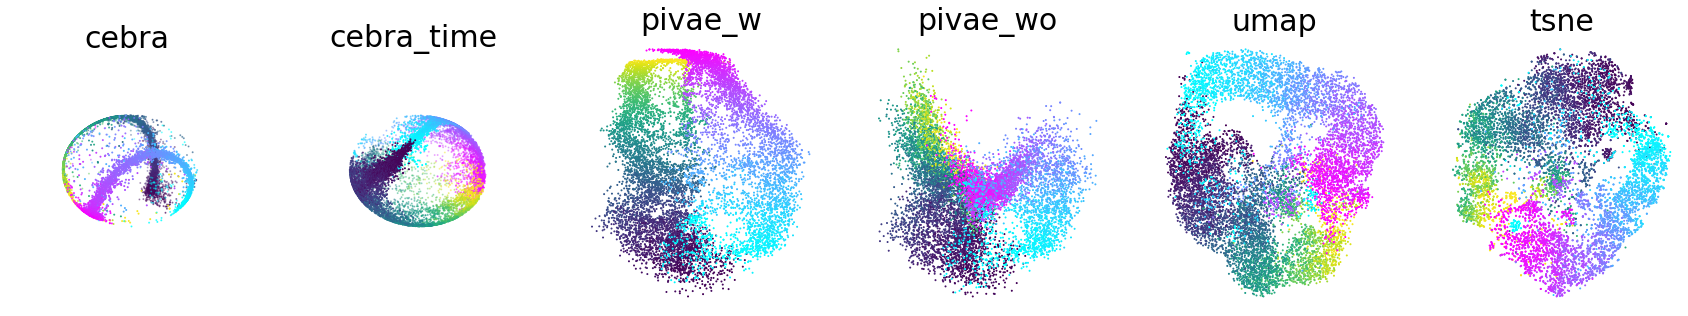

In [6]:
label = viz['label'].numpy()
r_ind = label[:,1]==1
l_ind = label[:,2]==1

fig = plt.figure(figsize=(30,5))
for i,k in enumerate(['cebra', 'cebra_time','pivae_w', 'pivae_wo', 'umap', 'tsne']):
    
    fs=viz[k]
    if not 'cebra' in k:
        ax=plt.subplot(1,6,i+1)
        ax.scatter(fs[r_ind,1], fs[r_ind,0], c=label[r_ind,0], cmap = 'viridis', s=1)
        ax.scatter(fs[l_ind,1], fs[l_ind,0], c=label[l_ind,0], cmap = 'cool', s=1)
        ax.axis('off')
    else:
        ax=plt.subplot(1,6,i+1, projection='3d')
        ax.scatter(fs[l_ind,0], fs[l_ind,1], fs[l_ind,2], c=label[l_ind,0], cmap = 'cool', s=1)
        ax.scatter(fs[r_ind,0], fs[r_ind,1], fs[r_ind,2], c=label[r_ind,0], cmap = 'viridis', s=1)
        ax.axis('off')
    ax.set_title(f'{k}', fontsize=30)